## Project Name - Cardiovascular Risk Prediction

## Project Summary

- The dataset is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has a 10-year risk of future coronary heart disease (CHD). The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes. Each attribute is a potential risk factor. There are both demographic, behavioral, and medical risk factors.    
- The goal of this project is to draw insights from the data which can be used to predict CHD based on indicators.

## 1. Know your Data

### Import libraries

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
import joblib
import session_info

sns.set_style("darkgrid")

### Loading Dataset

In [2]:
data = pd.read_csv("data_cardiovascular_risk.csv", index_col="id")

### Dataset First View

In [3]:
data.head()

age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
id                                                                       
0    64        2.0   F        YES         3.0     0.0                0   
1    36        4.0   M         NO         0.0     0.0                0   
2    46        1.0   F        YES        10.0     0.0                0   
3    50        1.0   M        YES        20.0     0.0                0   
4    64        1.0   F        YES        30.0     0.0                0   

    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
id                                                                             
0              0         0    221.0  148.0   85.0    NaN       90.0     80.0   
1              1         0    212.0  168.0   98.0  29.77       72.0     75.0   
2              0         0    250.0  116.0   71.0  20.35       88.0     94.0   
3              1         0    233.0  158.0   88.0  28.26       68.0     94.0   
4              0         0    241.0  136.5   85.0  26.42       70.0     77.0   

    TenYearCHD  
id              
0            1  
1            0  
2            0  
3            1  
4            0

### Dataset Rows and Columns count

In [4]:
data.shape

(3390, 16)

### Dataset Information

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


#### Duplicate values

In [6]:
dummy = data.copy()
dummy = dummy.drop_duplicates()
print(f"Dataset shape before dropping duplicates: {data.shape}")
print(f"Dataset shape after dropping duplicates: {dummy.shape}")

Dataset shape before dropping duplicates: (3390, 16)
Dataset shape after dropping duplicates: (3390, 16)


#### Missing / Null Values

In [7]:
data.isnull().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

#### Visualizing missing data

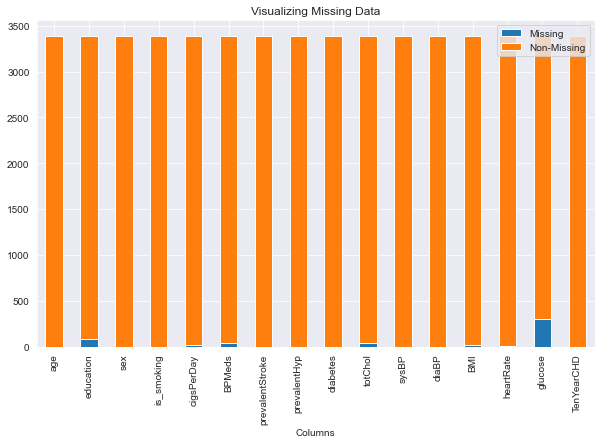

In [8]:
non_missing = data.isnull().sum().apply(lambda x: data.shape[0] - x)
missing = data.isnull().sum()
missing_df = pd.concat([missing, non_missing], axis=1).reset_index()
missing_df.columns = ["Columns", "Missing", "Non-Missing"]
missing_df.plot.bar(x="Columns", stacked=True, figsize=(10, 6))
plt.title("Visualizing Missing Data")
plt.show()

## 2. Understanding Variables

### Dataset Description

In [9]:
data.describe()

age    education   cigsPerDay       BPMeds  prevalentStroke  \
count  3390.000000  3303.000000  3368.000000  3346.000000      3390.000000   
mean     49.542183     1.970936     9.069477     0.029886         0.006490   
std       8.592878     1.019081    11.879078     0.170299         0.080309   
min      32.000000     1.000000     0.000000     0.000000         0.000000   
25%      42.000000     1.000000     0.000000     0.000000         0.000000   
50%      49.000000     2.000000     0.000000     0.000000         0.000000   
75%      56.000000     3.000000    20.000000     0.000000         0.000000   
max      70.000000     4.000000    70.000000     1.000000         1.000000   

       prevalentHyp     diabetes      totChol       sysBP        diaBP  \
count   3390.000000  3390.000000  3352.000000  3390.00000  3390.000000   
mean       0.315339     0.025664   237.074284   132.60118    82.883038   
std        0.464719     0.158153    45.247430    22.29203    12.023581   
min        0.000000     0.000000   107.000000    83.50000    48.000000   
25%        0.000000     0.000000   206.000000   117.00000    74.500000   
50%        0.000000     0.000000   234.000000   128.50000    82.000000   
75%        1.000000     0.000000   264.000000   144.00000    90.000000   
max        1.000000     1.000000   696.000000   295.00000   142.500000   

               BMI    heartRate      glucose   TenYearCHD  
count  3376.000000  3389.000000  3086.000000  3390.000000  
mean     25.794964    75.977279    82.086520     0.150737  
std       4.115449    11.971868    24.244753     0.357846  
min      15.960000    45.000000    40.000000     0.000000  
25%      23.020000    68.000000    71.000000     0.000000  
50%      25.380000    75.000000    78.000000     0.000000  
75%      28.040000    83.000000    87.000000     0.000000  
max      56.800000   143.000000   394.000000     1.000000

### Dataset Columns

In [10]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

## 3. Data Wrangling

### Grouping data by TenYearCHD risk

In [11]:
data.groupby("TenYearCHD").mean().T

TenYearCHD                0           1
age               48.728031   54.129159
education          1.993583    1.843373
cigsPerDay         8.734430   10.947059
BPMeds             0.023575    0.065476
prevalentStroke    0.004168    0.019569
prevalentHyp       0.282737    0.499022
diabetes           0.018757    0.064579
totChol          235.279494  247.216270
sysBP            130.603856  143.854207
diaBP             82.194338   86.763209
BMI               25.679565   26.452560
heartRate         75.875304   76.552941
glucose           80.662969   89.970339

### Grouping data by sex

In [12]:
data.groupby("sex").mean().T

sex                       F           M
age               49.856474   49.130198
education          1.944179    2.006329
cigsPerDay         5.628332   13.593814
BPMeds             0.036508    0.021291
prevalentStroke    0.007280    0.005453
prevalentHyp       0.314093    0.316973
diabetes           0.024441    0.027267
totChol          239.899364  233.431011
sysBP            133.328653  131.647580
diaBP             82.265211   83.692911
BMI               25.481353   26.205534
heartRate         77.217889   74.349932
glucose           82.252047   81.880814
TenYearCHD         0.124285    0.185412

### Grouping data by smokers

In [13]:
data.groupby("is_smoking").mean().T

is_smoking               NO         YES
age               51.346447   47.720806
education          1.942563    1.999394
cigsPerDay         0.000000   18.345946
BPMeds             0.036331    0.023395
prevalentStroke    0.009982    0.002964
prevalentHyp       0.370523    0.259632
diabetes           0.034058    0.017190
totChol          239.187093  234.928443
sysBP            135.833823  129.337878
diaBP             84.370523   81.381446
BMI               26.503738   25.079440
heartRate         75.236641   76.725386
glucose           83.565189   80.580772
TenYearCHD         0.138579    0.163011

### Grouping data by Diabetes

In [14]:
data.groupby("diabetes").mean().T

diabetes                  0           1
age               49.391765   55.252874
education          1.979497    1.642857
cigsPerDay         9.164279    5.494253
BPMeds             0.027914    0.104651
prevalentStroke    0.006358    0.011494
prevalentHyp       0.309113    0.551724
totChol          236.637979  253.448276
sysBP            132.152589  149.632184
diaBP             82.763700   87.413793
BMI               25.736035   28.076588
heartRate         75.900061   78.908046
glucose           79.571619  171.964286
TenYearCHD         0.144717    0.379310

### Grouping data by Prevalent Hypertension

In [15]:
data.groupby("prevalentHyp").mean().T

prevalentHyp              0           1
age               47.741491   53.451824
education          2.029646    1.843720
cigsPerDay         9.709635    7.683271
BPMeds             0.000000    0.095238
prevalentStroke    0.002585    0.014967
diabetes           0.016803    0.044902
totChol          232.175087  247.726326
sysBP            122.023481  155.567353
diaBP             77.882594   93.739944
BMI               24.956809   27.618721
heartRate         74.752693   78.638577
glucose           80.657820   85.175205
TenYearCHD         0.110297    0.238541

### Grouping data by Prevalent Stroke

In [16]:
data.groupby("prevalentStroke").mean().T

prevalentStroke           0           1
age               49.501188   55.818182
education          1.973788    1.545455
cigsPerDay         9.109982    2.909091
BPMeds             0.028271    0.285714
prevalentHyp       0.312648    0.727273
diabetes           0.025534    0.045455
totChol          237.114114  231.045455
sysBP            132.497476  148.477273
diaBP             82.837144   89.909091
BMI               25.789055   26.786500
heartRate         75.995842   73.136364
glucose           82.039152   89.000000
TenYearCHD         0.148753    0.454545

### Grouping data by Blood Pressure Meds

In [17]:
data.groupby("BPMeds").mean().T

BPMeds                  0.0         1.0
age               49.299754   55.560000
education          1.975016    1.855670
cigsPerDay         9.157568    6.580000
prevalentStroke    0.004621    0.060000
prevalentHyp       0.292668    1.000000
diabetes           0.023722    0.090000
totChol          236.363014  258.659794
sysBP            131.473660  165.890000
diaBP             82.438386   96.590000
BMI               25.738311   27.857700
heartRate         75.943606   77.220000
glucose           81.824247   91.043956
TenYearCHD         0.145102    0.330000

## 4. Data Visualization

### Chart 1: Ten Year Risk of Coronary Heart Disease

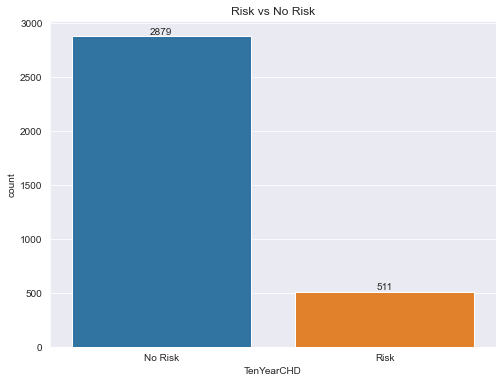

In [18]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=data["TenYearCHD"])
ax.bar_label(ax.containers[0])
ax.set_xticklabels(["No Risk", "Risk"])
plt.title("Risk vs No Risk")
plt.show()

### Chart 2: Age Distribution

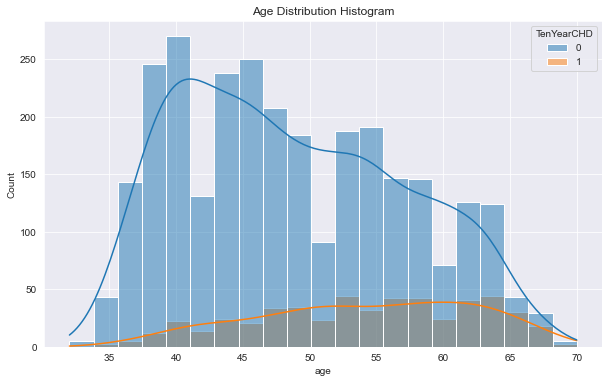

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="age", hue="TenYearCHD", kde=True)
plt.title("Age Distribution Histogram")
plt.show()

Inference
- As the age increases the risk of Coronary Heart Disease increases.
- Highest Risk is between the age 40 to 65

### Chart 3: Total Cholestrol Distribution

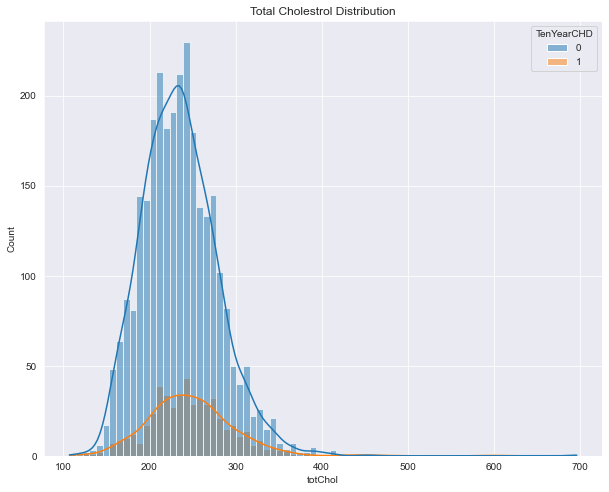

In [20]:
plt.figure(figsize=(10, 8))
sns.histplot(data=data, x="totChol", hue="TenYearCHD", kde=True)
plt.title("Total Cholestrol Distribution")
plt.show()

Inference
- Even though most common range of total cholestrol lies between 200-300. The risk of Coronary Heart Diseases sharply increases for people with Cholestrol levels > 200

### Chart 4: BMI Distribution

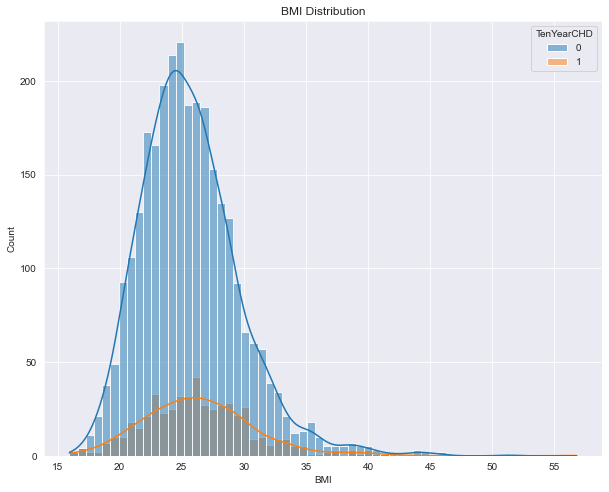

In [21]:
plt.figure(figsize=(10, 8))
sns.histplot(data=data, x="BMI", hue="TenYearCHD", kde=True)
plt.title("BMI Distribution")
plt.show()

Inference
- Even though most common range of BMI lies between 20-30. The risk of Coronary Heart Diseases sharply increases for people with BMI > 20

### Chart 5: Diabetes Risk vs No Risk

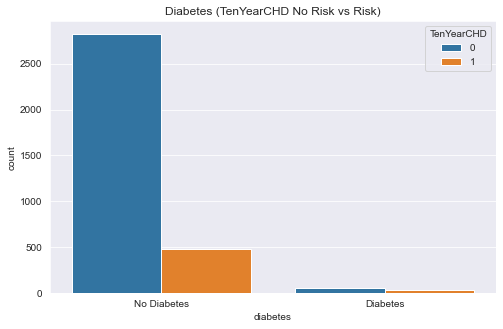

In [22]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=data, x="diabetes", hue="TenYearCHD")
ax.set_xticklabels(["No Diabetes", "Diabetes"])
plt.title("Diabetes (TenYearCHD No Risk vs Risk)")
plt.show()

Inference
- No clear correlation found between people with diabetes with risk of coronary heart disease

### Chart 6: Non Smokers vs Smokers

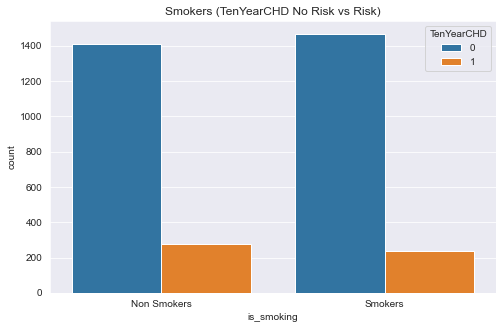

In [23]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=data, x="is_smoking", hue="TenYearCHD")
ax.set_xticklabels(["Non Smokers", "Smokers"])
plt.title("Smokers (TenYearCHD No Risk vs Risk)")
plt.show()

Inference
- From the above plot, it is clear that smokers have a slightly higher chances of contracting a coronary heart disease

### Chart 7: Heart Rate Distribution

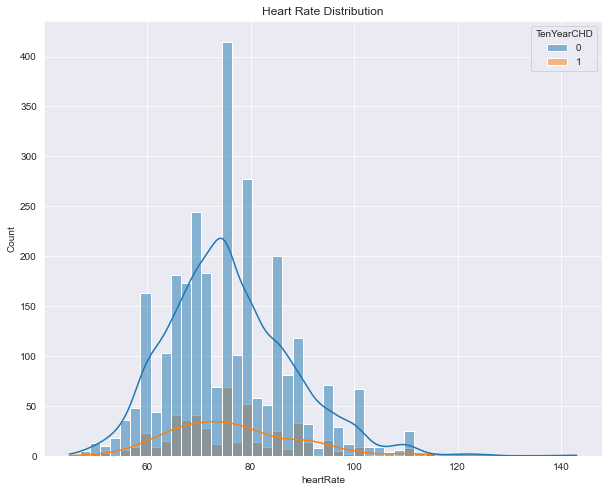

In [24]:
plt.figure(figsize=(10, 8))
sns.histplot(data=data, x="heartRate", hue="TenYearCHD", kde=True)
plt.title("Heart Rate Distribution")
plt.show()

Inference
- No clear correlation found between Heart Rate and coronary heart disease. 

### Chart 8: Glucose level Distribution

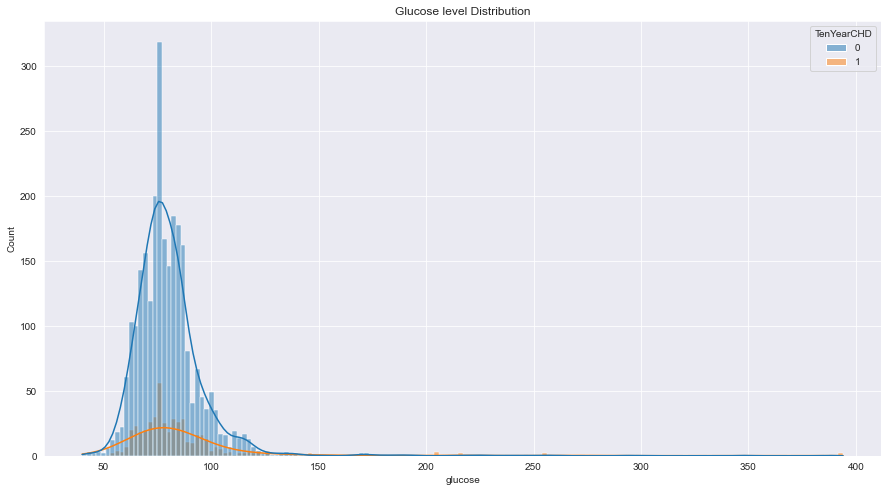

In [25]:
plt.figure(figsize=(15, 8))
sns.histplot(data=data, x="glucose", hue="TenYearCHD", kde=True)
plt.title("Glucose level Distribution")
plt.show()

Inference
- No clear correlation found between glucose levels and coronary heart disease. 

### Chart 9: Boxplot 

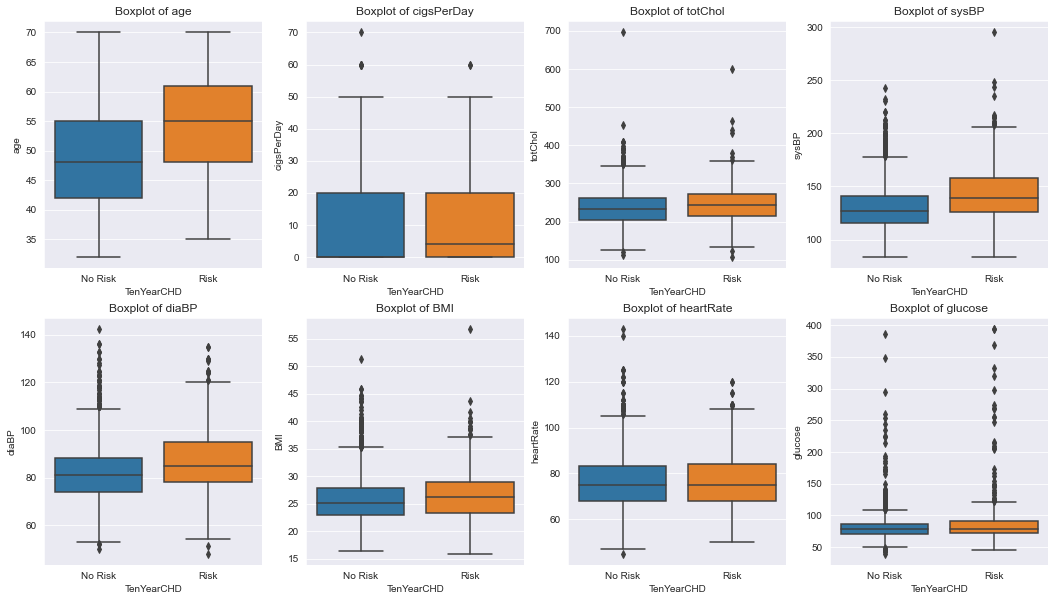

In [26]:
columns = [
    "age",
    "cigsPerDay",
    "totChol",
    "sysBP",
    "diaBP",
    "BMI",
    "heartRate",
    "glucose",
]

a = 2  # rows
b = 4  # columns
c = 1  # counter

plt.figure(figsize=(18, 10))

for col in columns:
    plt.subplot(a, b, c)
    ax = sns.boxplot(data=data, x="TenYearCHD", y=col)
    ax.set_xticklabels(["No Risk", "Risk"])
    plt.title(f"Boxplot of {col}")
    c += 1
plt.show()

Inference
- People with an average age of 55 have a higher chance of contracting a coronary heart disease when compared to the other ages.
- People with coronary heart disease tend to smoke 3 cigarettes on average.
- People with coronary heart disease have higher systolic and diastolic blood pressure when compared to people who do not have any CHD.
- The variables 'totalChol', 'sysBP', 'diaBP', 'BMI', 'heartRate' and 'gluclose' have outliers which need to be addressed to make a robust ML model.

### Chart 10: Pairplot

<Figure size 1080x576 with 0 Axes>

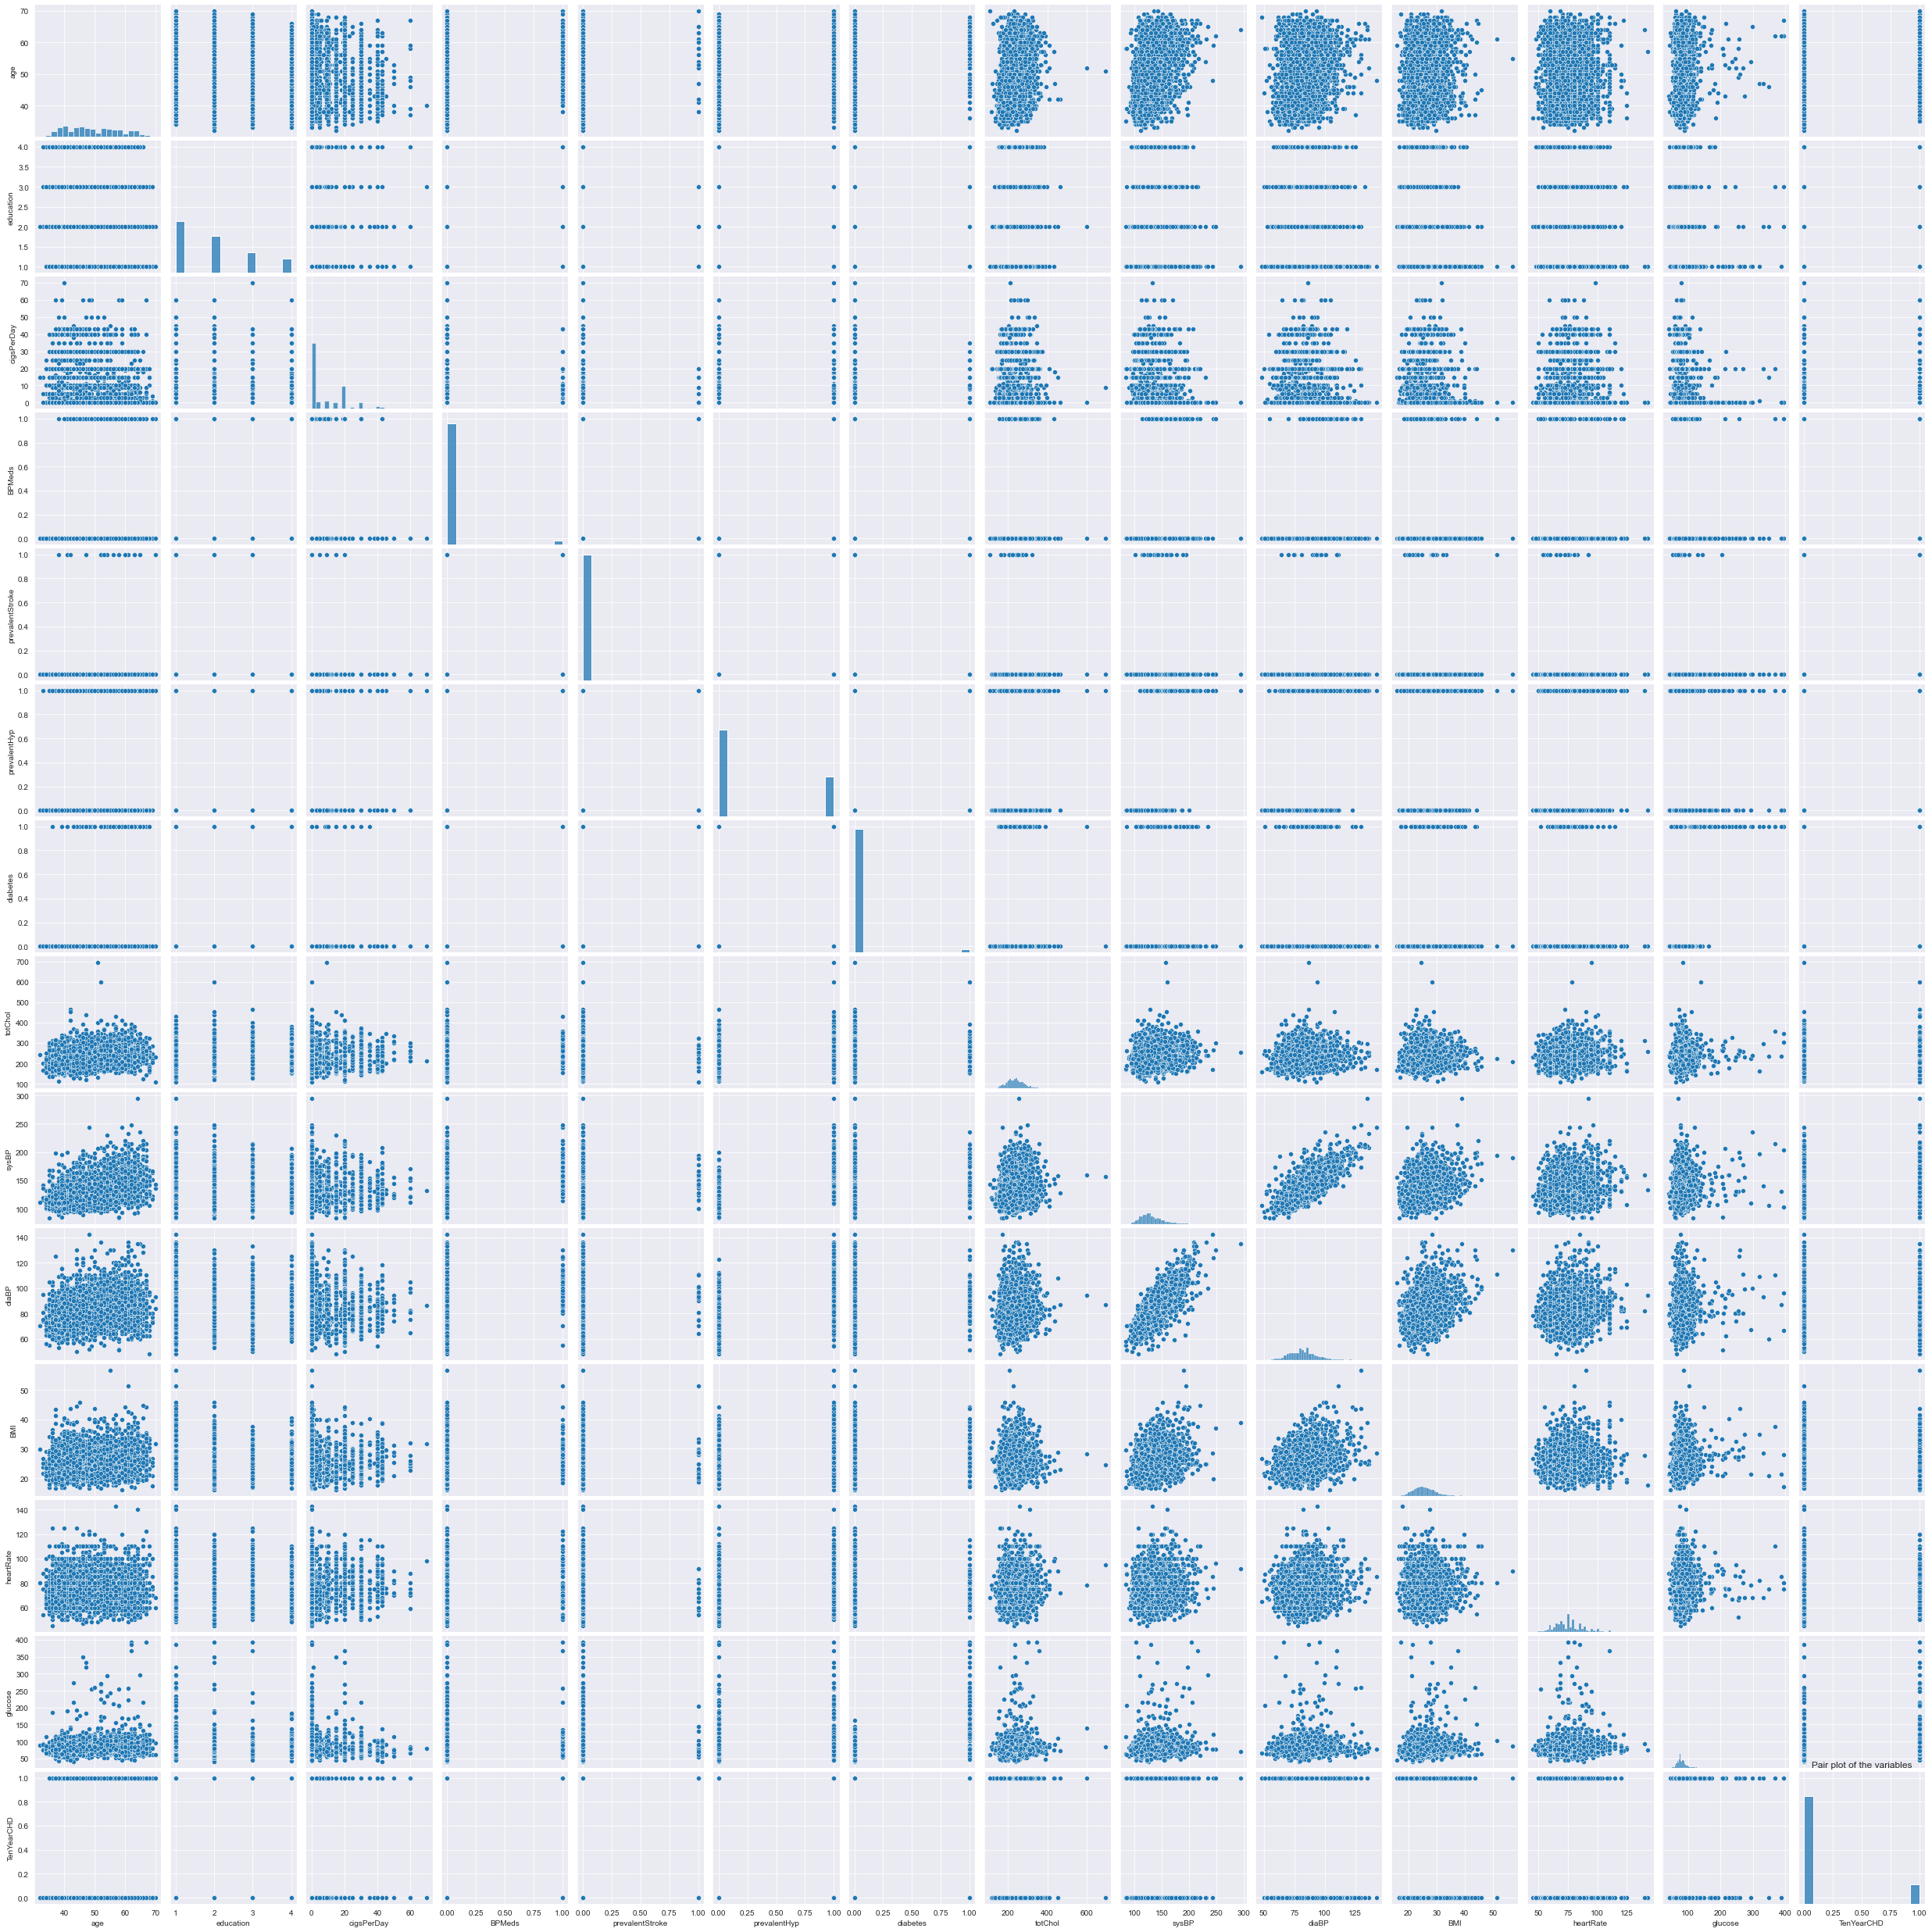

In [27]:
plt.figure(figsize=(15, 8))
sns.pairplot(data)
plt.title("Pair plot of the variables")
plt.show()

### Chart 11: Heatmap

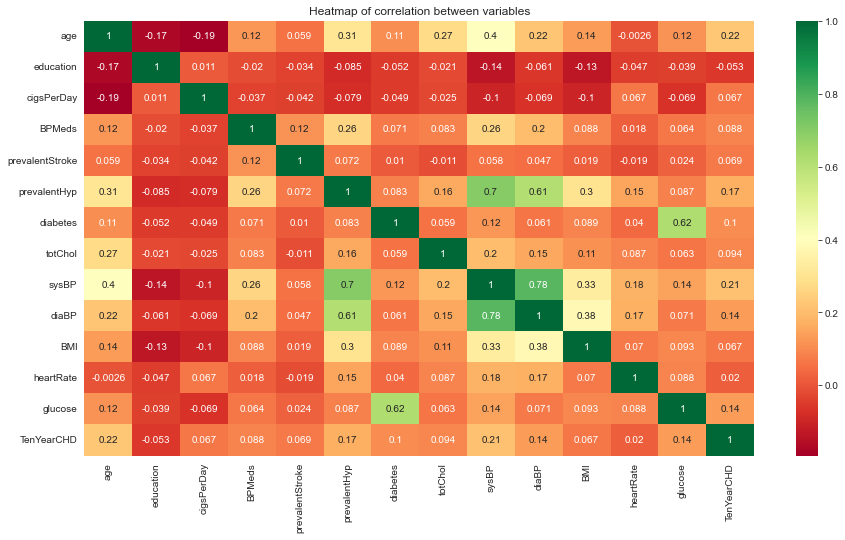

In [28]:
corr = data.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, cmap="RdYlGn")
plt.title("Heatmap of correlation between variables")
plt.show()

Inference
- High correlation between Blood Pressure (systolic blood pressure, diastolic blood pressure) and prevalent hypertension
- High correlation between diabetes and glucose levels
- High correlation between smokers and cigsPerDay

Application
- Can drop is_smoking variable as it is highly correlated with cigsPerDay variable
- Can drop diastolic BP variable as according to the domain knowledge, systolic BP is often looked at by the doctor.

## 5. Hypothesis Testing

In [39]:
def normality_check(data):
    p = round(shapiro(data.sample(1000).select_dtypes(['int', 'float']))[1], 2)
    alpha = 0.05
    if p > alpha:
        print(
            f"p: {p} > alpha: {alpha} : We fail to reject the null hypothesis. Data is normal."
        )
    elif p < alpha:
        print(
            f"p: {p} < alpha: {alpha} : We reject the null hypothesis. Data is not normal."
        )

In [40]:
normality_check(data)

p: 1.0 > alpha: 0.05 : We fail to reject the null hypothesis. Data is normal.


## 5. Feature Engineering & Data Preprocessing

### Dropping unrequired variables

In [41]:
data = data.drop(labels=["education", "is_smoking", "diaBP"], axis=1)

### Handling missing values

In [45]:
data["glucose"] = data["glucose"].fillna(data["glucose"].median())

data["heartRate"] = data["heartRate"].fillna(data["heartRate"].median())

data["totChol"] = data["totChol"].fillna(data["totChol"].median())

data["BPMeds"] = data["BPMeds"].fillna(data["BPMeds"].mode()[0])

data["cigsPerDay"] = data["cigsPerDay"].fillna(data["cigsPerDay"].mode()[0])

data["BMI"] = data["BMI"].fillna(data["BMI"].median())

Justification
- No information provided regarding education column in the dataset description. Hence dropping the variable to avoid any inaccurate assumptions.
- Replacing glucose column missing values with its median value to avoid skewing of data.
- Replacing heartRate column missing values with its median value to avoid skewing of data.
- Replacing totChol column missing values with its median value to avoid skewing of data.
- Replacing BMI column missing values with its median value to avoid skewing of data.
- Replacing BPMeds column missing values with its mode value as it is most probable assumption.
- Replacing cigsPerDay column missing values with its mode value as it is most probable assumption.

### Handling Outliers

In [46]:
data.describe(percentiles=[0.01, 0.25, 0.50, 0.75, 0.90, 0.99])

age   cigsPerDay       BPMeds  prevalentStroke  prevalentHyp  \
count  3390.000000  3390.000000  3390.000000      3390.000000   3390.000000   
mean     49.542183     9.010619     0.029499         0.006490      0.315339   
std       8.592878    11.862839     0.169224         0.080309      0.464719   
min      32.000000     0.000000     0.000000         0.000000      0.000000   
1%       35.000000     0.000000     0.000000         0.000000      0.000000   
25%      42.000000     0.000000     0.000000         0.000000      0.000000   
50%      49.000000     0.000000     0.000000         0.000000      0.000000   
75%      56.000000    20.000000     0.000000         0.000000      1.000000   
90%      62.000000    25.000000     0.000000         0.000000      1.000000   
99%      67.000000    43.000000     1.000000         0.000000      1.000000   
max      70.000000    70.000000     1.000000         1.000000      1.000000   

          diabetes      totChol       sysBP          BMI    heartRate  \
count  3390.000000  3390.000000  3390.00000  3390.000000  3390.000000   
mean      0.025664   237.039823   132.60118    25.793251    75.976991   
std       0.158153    44.994205    22.29203     4.107026    11.970114   
min       0.000000   107.000000    83.50000    15.960000    45.000000   
1%        0.000000   153.000000    96.94500    18.256700    52.890000   
25%       0.000000   206.000000   117.00000    23.030000    68.000000   
50%       0.000000   234.000000   128.50000    25.380000    75.000000   
75%       0.000000   264.000000   144.00000    27.997500    83.000000   
90%       0.000000   292.000000   162.50000    30.851000    92.000000   
99%       1.000000   355.110000   202.05500    38.835400   110.000000   
max       1.000000   696.000000   295.00000    56.800000   143.000000   

           glucose   TenYearCHD  
count  3390.000000  3390.000000  
mean     81.720059     0.150737  
std      23.161265     0.357846  
min      40.000000     0.000000  
1%       56.000000     0.000000  
25%      72.000000     0.000000  
50%      78.000000     0.000000  
75%      85.000000     0.000000  
90%      97.000000     1.000000  
99%     173.000000     1.000000  
max     394.000000     1.000000

Inference:
- Can soft can the outliers for 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose' with 99% of the total value

In [47]:
def soft_cap_outliers(data, cols):
    """
    Function to softcap outliers.
    Args:
        data(pd.DataFrame): given dataframe
        cols(list): list of columns for which soft capping is required
        
    Returns:
        data: modified data with soft capped outliers
    """
    for col in cols:
        quantile = data[col].quantile(0.99)
        data[col] = data[col].apply(lambda x: quantile if x > quantile else x)
    return data

In [48]:
cols = ["cigsPerDay", "totChol", "sysBP", "BMI", "heartRate", "glucose"]
data = soft_cap_outliers(data, cols)

### Converting sex to binary {0: Female, 1: Male}

In [49]:
data["sex"] = data.sex.apply(lambda x: 1 if x == "M" else 0)

### Dividing data into X and y

In [79]:
X = data.drop(labels='TenYearCHD', axis=1)
y = data['TenYearCHD'].values

### Handling class imbalance

In [80]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [81]:
print(f"X shape before resampling :{X.shape} | y shape before resampling {y.shape}")
print(f"X shape after resampling :{X_resampled.shape} | y shape after resampling {y_resampled.shape}")

X shape before resampling :(3390, 12) | y shape before resampling (3390,)
X shape after resampling :(5758, 12) | y shape after resampling (5758,)


### Splitting data into train and test sets

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.7, stratify=y_resampled)

### Scaling Train and Test data

In [84]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train, y_train)
X_test_scaled = scalar.transform(X_test)

## 7. Model Building

### Finding Optimal Model

In [ ]:
clf = LazyClassifier()

In [85]:
clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


  7%|█████▋                                                                             | 2/29 [00:00<00:04,  5.77it/s]C:\Users\shubh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\shubh\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 38%|████████████████

(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 LGBMClassifier                     0.89               0.89     0.89      0.89   
 XGBClassifier                      0.88               0.88     0.88      0.88   
 ExtraTreesClassifier               0.88               0.88     0.88      0.87   
 RandomForestClassifier             0.87               0.87     0.87      0.87   
 BaggingClassifier                  0.84               0.84     0.84      0.84   
 LabelPropagation                   0.81               0.81     0.81      0.81   
 LabelSpreading                     0.81               0.81     0.81      0.81   
 DecisionTreeClassifier             0.78               0.78     0.78      0.78   
 NuSVC                              0.77               0.77     0.77      0.77   
 KNeighborsClassifier               0.77               0.77     0.77      0.77   
 ExtraTreeClassi

### Hypertuning Optimal Model

In [103]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss
# from optuna.integration import LightGBMPruningCallback
# def objective(trial, X, y):
#     param_grid = {
#         # "device_type": trial.suggest_categorical("device_type", ['gpu']),
#         "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.95, step=0.1
#         ),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.95, step=0.1
#         ),
#     }

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#     cv_scores = np.empty(5)
#     for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

#         model = LGBMClassifier(objective="binary", **param_grid)
#         model.fit(
#             X_train,
#             y_train,
#             eval_set=[(X_test, y_test)],
#             eval_metric="binary_logloss",
#             early_stopping_rounds=100,
#             callbacks=[
#                 LightGBMPruningCallback(trial, "binary_logloss")
#             ],  # Add a pruning callback
#         )
#         preds = model.predict_proba(X_test)
#         cv_scores[idx] = log_loss(y_test, preds)

#     return np.mean(cv_scores)
# study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
# func = lambda trial: objective(trial, X_resampled, y_resampled)
# study.optimize(func, n_trials=20)

### Model Building

In [158]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

In [154]:
lgbmclf = LGBMClassifier()

In [155]:
lgbmclf.fit(X_train_scaled, y_train)

LGBMClassifier()

### Model Evaluation

In [163]:
def eval_model(model, X_train, X_test, y_train, y_test):
    eval_df = pd.DataFrame(index=['LGBMClassifier'])
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    eval_df['Train Accuracy'] = accuracy_score(y_train, y_train_pred)
    eval_df['Test Accuracy'] = accuracy_score(y_test, y_test_pred)
    
    eval_df['Train ROC AUC Score'] = roc_auc_score(y_train, y_train_pred)
    eval_df['Test ROC AUC Score'] = roc_auc_score(y_test, y_test_pred)
    
    eval_df['Train F1 Score'] = f1_score(y_train, y_train_pred)
    eval_df['Test F1 Score'] = f1_score(y_test, y_test_pred)
    
    eval_df['Train Precision Score'] = precision_score(y_train, y_train_pred)
    eval_df['Test Precision Score'] = precision_score(y_test, y_test_pred)
    
    eval_df['Train Recall Score'] = recall_score(y_train, y_train_pred)
    eval_df['Test Recall Score'] = recall_score(y_test, y_test_pred)
    
    return eval_df.T

In [164]:
eval_model(lgbmclf, X_train_scaled, X_test_scaled, y_train, y_test)

LGBMClassifier
Train Accuracy                   0.97
Test Accuracy                    0.89
Train ROC AUC Score              0.97
Test ROC AUC Score               0.89
Train F1 Score                   0.97
Test F1 Score                    0.89
Train Precision Score            0.99
Test Precision Score             0.90
Train Recall Score               0.94
Test Recall Score                0.88

## Saving Model

In [167]:
joblib.dump(lgbmclf, 'lgbmclf_model.sav')

['lgbmclf_model.sav']

In [180]:
session_info.show(write_req_file=True, req_file_name='requirements.txt')